# Direct spectrum estimation of speech signal

## Load packages and functions

In [4]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using Distributions
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [5]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 8000                        # specify desired sampling frequency

# inference and modelling
AR_order = 20                            # order of auto-regressive model
iterations = 3                           # number of iterations for variational message passing
Λ_meas = 1e3                            # assumed precision of measurement noise

# save file
savefile = "inferred_values/woman_AR"*string(AR_order, pad=2)*".h5"
;

## Load data

In [6]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time_clean = 100*x_time/var(x_time)
x_time = x_time_clean + rand(Distributions.Normal(0, 1/sqrt(Λ_meas)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time_clean, x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBAB9e99dwSvvOCzr0Y0K69b3FzvS43ALwLE4A9PwrqPS2aMj5i1Wk+OTqBPi5vcz4LIms+nr0SPofdnDzp1/68xy7UvHWp2705qEe+OFsmvn1Ulr2+b0K9u5EqvdpOhboVHD09fGo4PZfZhjygR428jt9TvbVHgr09r6q9xGHvvQanEL462+y9/NKlvUKogr0qtS+97VHvPH8A6z2nDy0+a0BQPq6/ej4dZoE+mVZ4Po8LJj7Vhh49mJHevFk927zBps69SxBNvhQPQb5tV8K93PdJvZUucb1yrs68ZAMhPdtScj2aZBE9V/o9PJe7jrzOwEW9zzyavaBCy720ZAm+ZtIFvoLa0L09q5u9T9MvvS96HT2vDQk+sAJBPn7zYj4TpYY+TJaNPlDAWT7IHZU9FNb8O8hZEbpm2pm9CmlSvmQjYr40YQa+t8iqvWqMyb1nt469zvPMPBSUrT2LmHk9BNKcPKKDTzzImM48Dx+PvBGavr3cYAW+QgbqvT2b0b1XLdK9wKGpvTpBrLutIrk9gUgiPuJjQD5tzGc+rCCJPoBiej6M0QI+iiNXPDReaTvA/ae8CwgWvsZwdb40wze+9pzcvd9B4b128N29QiUTvd/CBD2nH1M9rgsTPaeHVTww2mA7ortsPB63j7wqI7i9aorUvauXT70Jfd+8Q03xvH55Qz2hYzA+6nhpPsFdaT7KQGw+iXodPgstij0WuUA9UY0TvBSXIL7Hmla+E3sUvik//r2/jSC+DXLxvZ0udrxwSEE9uziEPXhcpz1qNIQ96sMqPfDiNz1F2o08PQSkvZe8Dr6xq9G9i5G5vQeLEb66tAW+e2QPvRwSAD2VrzI99k6vPccDFT77MTE+6tkZPlnF+z0vzsU984ODPelYqTwCeOG8tawmvfsbMr1aWqe9bVbrvStAqr3DyGi9vkmPvcRBhr0KA0u8090dPNbah7zXSgu9XqLQvJMyhLxwj4W80YAsvGh7QDzEEYM9CVYBPr8/Lj7yH0k+M4VxPisqVD5Ul4A9OtEtvOo6ujzopSm9teZUviMqXb6iR8W9f9mxvV7aHL5BZra9Fno+PVGxvD3tBYw9iPCwPTYt+z31OfQ9E4ybPd+lXDxzWhi9DE+AvQTjkL05d+C9QrwKvj49170PI0u9Y0AqvUAdGL0/LQu6J9EtPW4rJz33pcY8xK/FPPeazDzyzqo7Q5/ovEA2EL1Gy8a8in2jvEWD4LwGENO8mgaZvLS0Crt35rM7HrrfOgpbo7sOe5E7Gf/8O2iK2bsS7cC89xiYvBVs0ruoFWi8m8cGvHOuPjwCvr481m6zPHGR+jxvWh09Wl8xPfS6Dz3U+r88ZLyAPA62Rzw+xKU6eNW/vAFEB71i1wG9ti0fvUnDWL2fBzm9FC0QvagbEL1FaAu9xoirvI7zZLzvW1O8M/qju4tkkjuTdxw8Ki2hPAh1HT1R7jA9qvc3Pbfsdj3ryI49OXF0PayLPD0K3AI9MMuvPEC6OLvDNfK832FyvQJ8nr0HUae9xUynvTRgvb0fR7S9wB99vYjmOb1wcha93W2kvIXwkbk1PD88fRHGPGOfAj2SwCM9hymCPXbZuj1dEts94cn7PZaLAT6YF9A9Iw13PcnyNT0wD1274IOWvRPi2r2xGdW9EBIBvksvIb4yNQi+rKS1vetRmr0BGIy98IPjvIWSMDySMbI8DUAAPQPgVz3b35E95U2ePbr8vD0oavY9jrsVPujFIT6SK+k9YLcMPW/EpzyOTA89TmUXvQlVB74QmM69mOhBvW6w0b1hnAq+EJ1ovQLrTTtQ1te8YhFWvLH0XT2muJA9EDIYPUGeGj3+3lc9jiCtPBvftLzV+c6843HavPE1X72BCoq9AMlzvZ3eXL2dlEa937wVvdR8przf7A+8VwspvJZvB7yhbxE4qVgtPFAE+zq/mfm7e74YO4EoszucLvu7jI/nuyQnkjtB+Zi7uHhcvO9ZJ7xtJ+O7DWjlu8ncgbtHNgk7KTV5O/VerzsV8M47xxwLPNcnuTw6ask8xCxxPF9zNTyu+Kg8+TmWPDL7IDwa8GY8EDl9PHm/mDuiTo66VoYSut4TsbvDUta79YXhu7jWyrs4Z8+7yIrPu/0blLqB9xq7AktYOgaDkTsavj87fm0EPF3Tcjx+rvQ7UzMUPL88nTwduFI8W2g/O8vRJTznb5g8eVgrPJamoDtwmIg7pSiNul4WuTsRHS88Sa3Xu3nW/7v1GwU8TOrSO7qLyrukUoo69dVPO5hFIzcqgrw78UVyO0NMbrk2MYc7E/QpPMo3rDvOny06Ii0QPLoXlDurnlg8x4/iO1/7NbkfJqQ8JeAjPJIftTs+YIk8fXbxOn7mxbjL0no8bIPqO1ZzTbwTn5y7LMkYupCtLrwZHBO7CvmKOcMtBryvGMk7SKueu3YYpbw65Cg8YQ2kPACnTbzM7dy8SCQDPN79vTwiN6i8cS6HvORYyzyBu2m8yNWzvOqJ1TyE4Bm7ZwQkvRG92DrCDFE8n1PKvKJU5LxgjoK7pm8DvBMEkLyGdLq7fymbvC2IKrx4yGQ893BIvPbDBr1j+yw8ArTaO6Gay7zyVhO8i9dpO6BdA7zCdIe8F/V5u0Lonzq4VJS8sDF5vKluorvly627c+iPvHQxhbyqJb27mvMhvBN8ArztXLa7wPAJu7Y38LpsjDy7x4ZBu/VTVrhxrPo6JlCdu7cPabsLlqG6UGGtuo0JQLv5ld+7SgeFuwYTkbtDqUK6tByqOVNtcrnvad+5FPxtOwpZg7ls1IW7wCYNuw1BobvTbfa7hMz7u7INz7vljve70kw6vNosB7xij667fGLbuhapVLuj1Da50vDNO0RxvTtDUBI7wgJpO0jYoTtQR+c6hVakOj1uqzp2LSq6q8AXOEQYQ7ofW7O6Z7HUuiwl5LqJfF06rEXFubuDjrvehJS7Kw+6u/Ofy7twMM67rOa5u+Qa+LpN6+W4qQFDO0A6Gzoo2wa4azaOO0kppjsV0Zs6MgGNuqrnTjuC+V07vTzruqMAXrp53187Fq5YO/i9mbkV9QW5kTJhO7gnaDuhfaE7Rte7O4JE9zvSAcQ7chLkO8VBtzucwo47tjWtO5gzQDuZH3E6yflmO034YTtcJts7RtG7O5CIfDtQ9pg78xGVOySSejuRC1c7G+apOzHN6zv6t3E7ZVwvO6fksDtv2Iw7ONLDOxUTITwd8gM8j6SuO7VwxTuYXcM7f9qYOhBgbDvnEPs1iYqDuwksrbsIkaK7wV5Vu2mOk7sRyAK6LFYVOz6UBTrZ9Am4Go6YOm479jm1xUu7F2aku2KQ1btoLfi7m8L1u91uKrwYXki8I1lBvPTzL7xD3Vq8lNQtvACRGLzw4zi8Uec8vJfSO7zA+j682IxqvM3EWbxg83O8ekh0vMDobLxNNF28GpRwvNgRY7xNhQS8fb44vHkXM7yVvxi8joMPvESTELyVYVi8rxNcvA4zZ7ytGUG8FcYzvHmGN7ym2TO8wQoovKDSNrxctEu8J+xFvGPzCrzKCBq8q+ExvEG2CbyRoNK7MA72uyCTortPpnu7RLD2u74Q37va/4W76CtYu26rVru8q4K7OPKau/I8N7qPAee64ClzurKOszmECk84NfDuOrUSQDrinhs5L0AVO+6f77rMY2u7ATunOXInZLmB/0s62PwgOfNScjuqBkM7KHANOxfTqTuG/cc78LurOyswHDwXOOM7LgnbOwpWxTsELLA7G6jgO87dkzvbIvY78Je1O3iDhjvJppM7t/r8O09r6jvDArY7CJANPG47DTwXx6I7F8jVOxyXCjzxgiA85pklPOLZGzzF1w48TqEkPNsgRDyzpw48a/raO1LkDzxfA

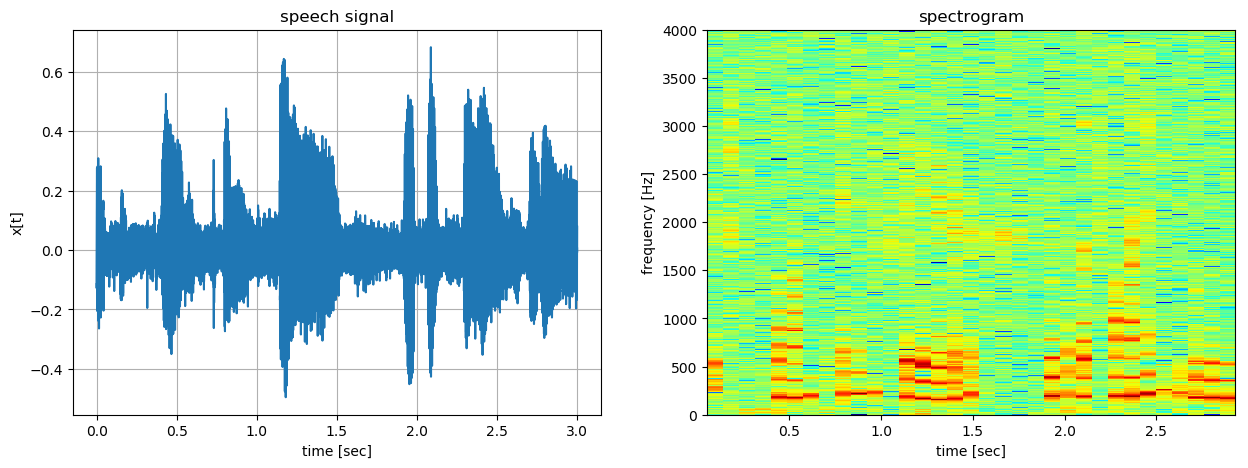

In [7]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [8]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV y ~ GaussianMeanPrecision(x, Λ_meas)
placeholder(y, :y)

ForneyLab.draw(fg)
# ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10146194605711328492 -->
 10146194605711328492 
 
 placeholder_y 
 
<!-- 5238968694167723770 -->
 5238968694167723770 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 10146194605711328492--5238968694167723770 -->
 10146194605711328492--5238968694167723770 
 
 y 
 1 out 
 1 out 
 
<!-- 277789633467078335 -->
 277789633467078335 
 
 placeholder_μ_Sprev 
 
<!-- 13683592737641381635 -->
 13683592737641381635 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 1116516460549956690 -->
 1116516460549956690 
 
 placeholder_μ_θ 
 
<!-- 13683592737641381635--1116516460549956690 -->
 13683592737641381635--1116516460549956690 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 10713578730639227203 -->
 10713578730639227203 
 
 placeholder_Λ_θ 
 
<!-- 13683592737641381635--10713578730639227203 -->
 13683592737641381635--10713578730639227203 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 559490076711099394 -->
 559490076711099394 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 559490076711099394--277789633467078335 -->
 559490076711099394--277789633467078335 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 13840286867142404373 -->
 13840286867142404373 
 
 placeholder_Λ_Sprev 
 
<!-- 559490076711099394--13840286867142404373 -->
 559490076711099394--13840286867142404373 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 8604682335122071420 -->
 8604682335122071420 
 
 placeholder_b_γ 
 
<!-- 5292009006183221379 -->
 5292009006183221379 
 
 Gam 
 gamma_1 
 
<!-- 5292009006183221379--8604682335122071420 -->
 5292009006183221379--8604682335122071420 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 241478188889780629 -->
 241478188889780629 
 
 placeholder_a_γ 
 
<!-- 5292009006183221379--241478188889780629 -->
 5292009006183221379--241478188889780629 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 4566166692664997212 -->
 4566166692664997212 
 
 dot 
 dotproduct_1 
 
<!-- 17849526453325656007 -->
 17849526453325656007 
 
 AR 
 autoregressive_1 
 
<!-- 4566166692664997212--17849526453325656007 -->
 4566166692664997212--17849526453325656007 
 
 S 
 1 y 
 3 in2 
 
<!-- 6420185439633186456 -->
 6420185439633186456 
 
 clamp_1 
 
<!-- 4566166692664997212--6420185439633186456 -->
 4566166692664997212--6420185439633186456 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 17849526453325656007--13683592737641381635 -->
 17849526453325656007--13683592737641381635 
 
 θ 
 1 out 
 3 θ 
 
<!-- 17849526453325656007--559490076711099394 -->
 17849526453325656007--559490076711099394 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 17849526453325656007--5292009006183221379 -->
 17849526453325656007--5292009006183221379 
 
 γ 
 1 out 
 4 γ 
 
<!-- 5238968694167723770--4566166692664997212 -->
 5238968694167723770--4566166692664997212 
 
 x 
 1 out 
 2 m 
 
<!-- 14169903432156648511 -->
 14169903432156648511 
 
 clamp_2 
 
<!-- 5238968694167723770--14169903432156648511 -->
 5238968694167723770--14169903432156648511 
 
 clamp_2 
 1 out 
 3 w

## Algorithm generation

In [9]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, [S, Sprev], γ, ids=[:θ :S :γ])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
println(algo)
;

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:S_Sprev], marginals[:θ], nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepS!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 6))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_Sprev]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Λ_Sprev]))
messages[2] = ruleSVariationalAROutNPPP(nothing, messages[1], marginals[:θ], marginals[:γ])
messages[3] = ruleSPDotProductOutNPG(nothing, Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [10]:
params = h5read("inferred_values/woman_AR20.h5", "parameters")
;

## Perform inference

In [11]:
# create memory variables
a_γ_mem = Array{Float64}(undef, length(x_time))
b_γ_mem = Array{Float64}(undef, length(x_time))
μ_x_pred = Array{Float64}(undef, length(x_time))
var_x_pred = Array{Float64}(undef, length(x_time))

# set priors
μ_θ_min = params["mean_theta"]
Λ_θ_min = params["precision_theta"]
μ_S_min = zeros(AR_order)
Λ_S_min = 1e-4 * Ic(AR_order)
a_γ_min = 1
b_γ_min = 0.001

# create progress bar
p = Progress(length(x_time), 1, "Observed ")

# create marginals dictionary
marginals = Dict(:θ => vague(GaussianMeanPrecision, AR_order),
                 :γ => vague(ForneyLab.Gamma),
                 :Sprev => vague(GaussianMeanPrecision, AR_order))

# create messages array 
messages= Array{Message}(undef, 6)

# loop through samples
for k = 1:length(x_time)
    
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data = Dict(:y => x_time[k],
                :μ_θ => μ_θ_min,
                :Λ_θ => Λ_θ_min,
                :a_γ => a_γ_min,
                :b_γ => b_γ_min,
                :μ_Sprev => μ_S_min,
                :Λ_Sprev => Λ_S_min)
    
    # get prediction
    stepS!(data, marginals, messages)
    μ_x_pred[k] = ForneyLab.unsafeMean(messages[3].dist)
    var_x_pred[k] = ForneyLab.unsafeVar(messages[3].dist)
    
    # perform variational message passing iterations
    for it = 1:iterations
        stepS!(data, marginals)
        stepγ!(data, marginals)
        stepθ!(data, marginals)
    end
    
    # update priors
    μ_S_min = ForneyLab.unsafeMean(marginals[:S])
    Λ_S_min = ForneyLab.unsafePrecision(marginals[:S])
    a_γ_min = marginals[:γ].params[:a]
    b_γ_min = marginals[:γ].params[:b]
    
    # save infered parameters
    a_γ_mem[k] = a_γ_min
    b_γ_mem[k] = b_γ_min
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:07:57:40


## Predictions

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQDFIeu9zc8AvvjhA77XdJa9J/IDvpPeQzzMH3s9t48EPmjoTD4BMko+hJ2NPhvjTT4Nx2Y+OOooPvSo5jyuvAQ9GpqpvOJzvr09J1K+ASUZvtRrWLxZOJe9wdCEvdcNgruOEEo9Ca4gPbaNaLkC42s8yI6DvaodSb1Q3C69L1rbvfDvB74rW8q9ISevvRd/Bb720Ue9X3RZPRlrCT5RZ/w9wsB1PrcbkD41iXY+gHldPkMSUj6z1lk9abb9vM2yYL3M8em9DmM1vgygTL4eGee9nkxHvaLsur0m9b+8v1IKPsq+lz0VKcg8cbxiPUQ5E71D+M29fPfqvSq6CL6rjwS+VJoTvr7N1r1/JJ298SmTvUk99Dw7RY494dIPPla0Oj5IkoU+uSSePlBIYD5BbJM9c7y/POmIOjyWPuO9t7l0vuY7VL4yzhi+4+aBvQwKBb6ZAT+9NGWgPGzwJz09yto8QLa5POHorTvhbxq8hx+UPGF6zb3KUxW+YQ/evQ7Os70DyIW9ho1FvSxf9jy+Cos9F3E8Pq8lUD6qEow+E8NjPk7ihT7pXNQ97bkROyiK37yw2aO8ha9PvqIOab59Uoe+32DXvQVS5r3Ese+9NRImvaGwcj0gU3I9GykFPNhckD1o1449T6CNPTCOv7xiHEe9G34dvrhP/b0lYzm9KiSmvCjBuj33PEc+OZV/Puc2hj4GFWE+TP8gPihRxj3y4QM9ZDjnvLeoML4kg16+9L4PvtRSJr6ZOfe9P8vEvantar22ABm8SmspPVaxYD3V0V49xkdsPWzXbz1hJ5s8xaj2vLg1+723tAy+ZzOsvZjU9r18ne+9ZUSjvMisHj2bj7M9wSxbPRd5OD4iLUw+N1laPocs2j0E18U9liPKPRfgAz1nf9O9VN/nuiOHar3HEl+9Vz35vc95Ur23wY292DvNvQG8FL1Ag5w8zKNWPUlcjbz9F4i9WpZLvbumtrwawcK8w7guvChULryoxWg9m+cSPq9kGz5Unys+rkWQPg2ALT6ALf89l3wkPOSCiTyDHca9ju5ovvyRV740xTK9Tq2gvW4FCL4hqIe8braDPSftEj7rwRA9LrabPak9wD0cWv89YUwePR7+sDy3i/C8fjJfveTOob0MkJS9Ivs+vtwcyb0Wxp+9RKSWvey5LbzrezM9YMhSPWbtoj3LtIs9Dx2pOzUeCj3Kghs80jbIO2pUuL0+GOG8TU+GveKPHbwvVfW8XPxEPJaDFLzCacS7qhfPvDE4FDzDOQA9V0YivcRjuDqhjFa9b0W/vccSvbzIASK89uukvFMwhD1KaR09z/KxPVhaTzxY+b09ofCSPZaqBbuGDfC9Mz4EvUuDb72MXjW90SF4vADI9736dua7wiCcOgQQvb30wX69RsoVvRsDMr0P6qG9enyHvKDN8Tz0Wey8jOOePI+wtjxFZFi8dlYjPNBiPT3EqW098/qhPWf9lz3ayw68z3AmPAadkD2ahRg9RQNAPekjITzrpm69V/bevCGfDbz/0gy9xFCJvd//Gr487Aa+lRHlvJIpv727da69t/yKvI3+rbzvpoU9AdHFvC69yDzEuMI8/y27PValWT10beM9cG8ZPrrvuz2cdv49fSNRPSzisTuUDrA8IMstveB/v71MoP69JHUGvi8qNL4nZAG+BM4QviJgRb38cYW9B7BkO/Xyhzy/e+E73saePacmmj2A/s49fPKRPZIdoT2ZKyU+tMELPrqyKT6TcMg9KEu3POymEL0gjYE9PncQva1uu71pBoi9bTOGvbvOrru7HVG+iCpRvaWtzLxcoZC9z22VvNImgz04l4w9ZOgVPYooFzuEMoI9UfBIPXyBej0Z0Re9hZ4BvbKiV72mhpy9mdUevRUyAT0pCkm94dUEvQ4glTyzBJi9Fm95u3FIhDy9o029BoWBvYf+B71wC1C9H2LBvAArkr3BzA29V4hguj5ePDxPbru8I1eyPBwwA73wJnk8cd5ivMkbOLxSj4I8cDmYu+Q/nbwehO68cbnAPNbz3zqWYQY9sbYdOkCkmjzjCJo9MpB6Pdpgu7wmQgE9+fDaPTbsB7st/u07JO8svHPdoLyVAlu94pDFPJRsPr0n4OS8JlGtvKixnTx+Hnk8Yz8XPcMkDr1SEOK8RtL8vL1WCjwMJug7qfEEvRAz5zxLiHY89v+cPLFRlD3TjDA9qHmQPKXVQL0cGw89RKVCvZ+MvDvxyt08JSAOvWYairxFoaW8Z0CrvG3zabwhdvO8ZZ0qvS91Yby8zLk8JS4avE462DzvmZk6+1AsvGJxyDog3wQ9H3EEvADilrwrgMG8mlr+PNP46ju/igc8YpFHPOu3SLx5p728J8jEOjWijjsrltk8S4t4PK6QtbzJxuS8gphaPL8I9bz4Rou7TE2gPH0Z/bySly+7/Z+hO8iLmLzYZRo9Nh0dPcWJNbwHM0o8lm2vPP3lHr3wXwK9dJeXO8LYej1ar2A8QfGrvbgEuTwvvC29I9UwvYX5HD2NFFQ9I0sNvWwjOL1fvgc97Eh5PEuuiLy50CQ5zqCvOTAQCL2VvRE9054ZvU5o/rwOmh68OSFPPRfGAb13DAg8pkcZvOtrhjzbCPG89WLhu5qSFjqfe+Y8diSxvQxKjzsxLw49qkjuu76QCr2p9dC8AgZ1vNJNoLzJbcg85OoFPfpEIj3ez587t9UVvdbfV73mLBs8VdEIPEwgqLyl0cG7O828um9hT7tD3249Dh/lvJkAAL2Ui+A8/jkxPWgnjzwXziI9mp5kPJcEsr3NyUI7Aeq0O+oerLwGGUm94WHTPM1PvzsP4DC7fpOFvM/IkryZKJc6nCsFvOAWaDyupzg8xbWjPAki7bx5O8M8b8+dO4yPdjsS7Sc9njRBvXH0lDz9REy8BgWHvd1UKL0gJ6i8gOxwvX5jyjyAyBm9WFopPSypab10Vp+8v+0BvJhuNr3PN4u86cILvXmQijwbT3c8FAwZu7PASL1Z5sI86H4kvFrBMb2i4VE8J1ktPD4WOL2aB2e8eMKyPAMzL737V0c9WmwjPDaRjjtuUao8VUf0PHTQpzwIhpG7JKBpPePwi7qGeRg79404vVZAjDuEAAg67kh2POKpsLz7Tt28csjpOqYa+LyzGy89p3ZOPd7Mfb2JhhQ84mO2PE1nujzUhAK9kbvGvCcC2jyJNdQ8eiqYvBf54buNsKe8v0hNPQrmPz2JaEs9eVASvBCnrrzAaf87XuUHva6AN7omPDw8ZhwMvf1DvDwa+Hw863MoPHUIFr0I4/E89sOCujvff7yYVpo8AsKIPNi6mjvtIZs73p/8vSY7QzxjgBY8bZaXPKgJn7rJZCU6Ig7QPGiRIzzo8Si9H+iSu4aWRjv1A/+8qBUfvclMe709qi08c8e6Ong8vL3qqmG9CgaMvVtcTLwHVZw5n1aIvbiPRjzIhOs8nW2zvPwQLLp9xxG92myUPFuy47ydHa68JeQPPR53HL2Xatg7QZEdPdbe0rzzpYA81KKBvNTxoLw04Tk84cD9vDUiv7qKTwq9EQKYvAwDfb1Oo3I8XuyyvH0X6Lu6R+I8mLOAvEaalzrJjV89eAuwPM2gOTygu9C7oO0fPaWbpT1BnV48VsXqu6vnIz10iLq4nzC1PKRGKz0D8uu6k9CFvC7qbT17F+C7lG+puoercr2m+qa8EzWcPN3ZQzzvqXu94DoKPBk40rtTYrM8Hrjguw/K2byQ4Cc9lGKaO6WC6bxseZo8JUibvNoG9Dyshl48HQYnuuaNVrw+NGE8dAI9u2n90jwX76A8DtfgvO89yrrAJMU9tFLmPLzOWj3WX2w9fEOLPVEunTzPD7g6+oZOPCvFRz299W68bffLO/03/rzTx

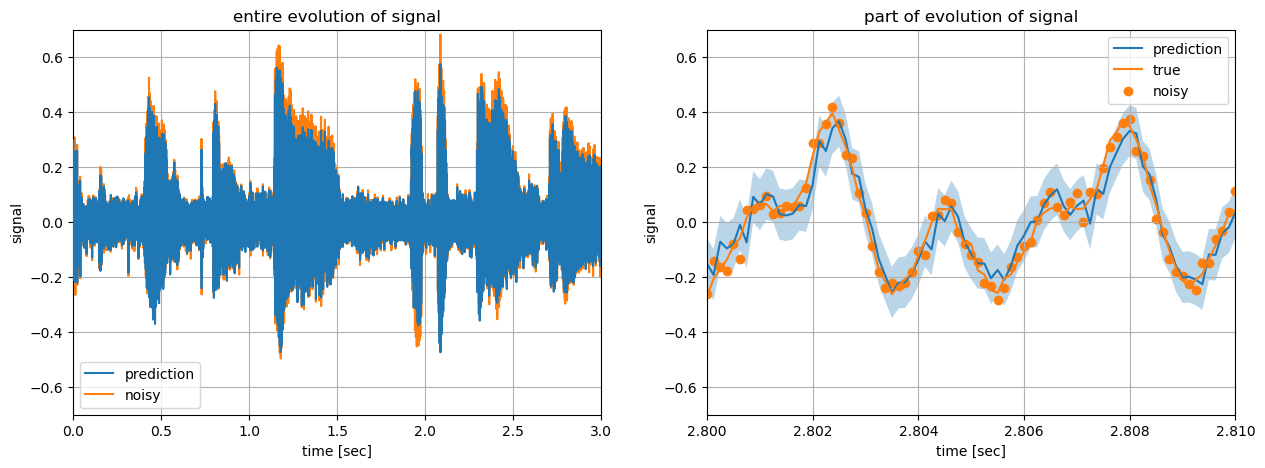

In [12]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, μ_x_pred, label="prediction", zorder=3), ax[2].plot(t, μ_x_pred, label="prediction")
ax[2].fill_between(t, μ_x_pred .- sqrt.(var_x_pred), μ_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="noisy"), ax[2].scatter(t, x_time, label="noisy"), ax[2].plot(t, x_time_clean, label="true")

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(2.8, 2.81), ax[2].set_ylim(-0.7,0.7), ax[1].set_ylim(-0.7, 0.7)

audioplayers(x_time, x_time_clean, μ_x_pred, fs=fs_desired)
;

## Visualize parameters

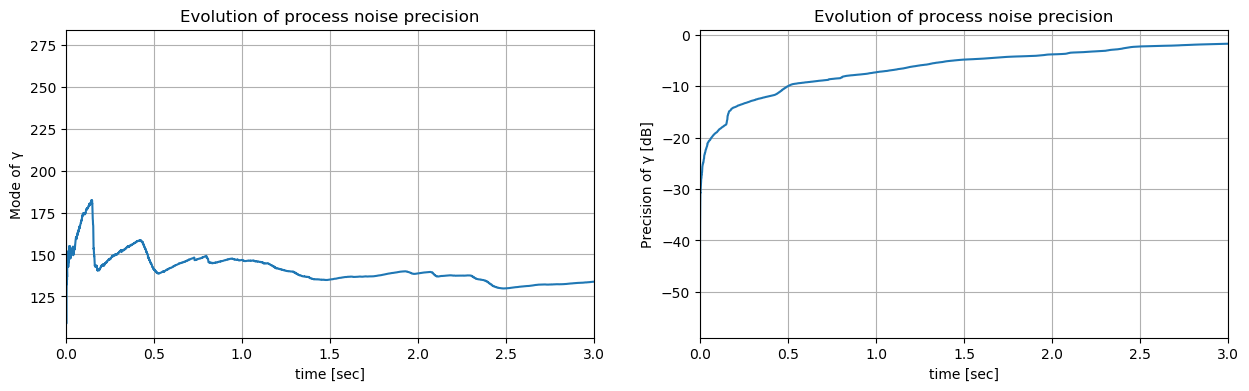

In [13]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_γ_mem[k]-1)/b_γ_mem[k] for k = 1:length(a_γ_mem)])
ax[2].plot(t, [10*log10.(b_γ_mem[k]^2/a_γ_mem[k]) for k = 1:length(a_γ_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of γ"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of γ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

## Plot final spectral estimate

In [14]:
using Distributions
include("visualization.jl")
;

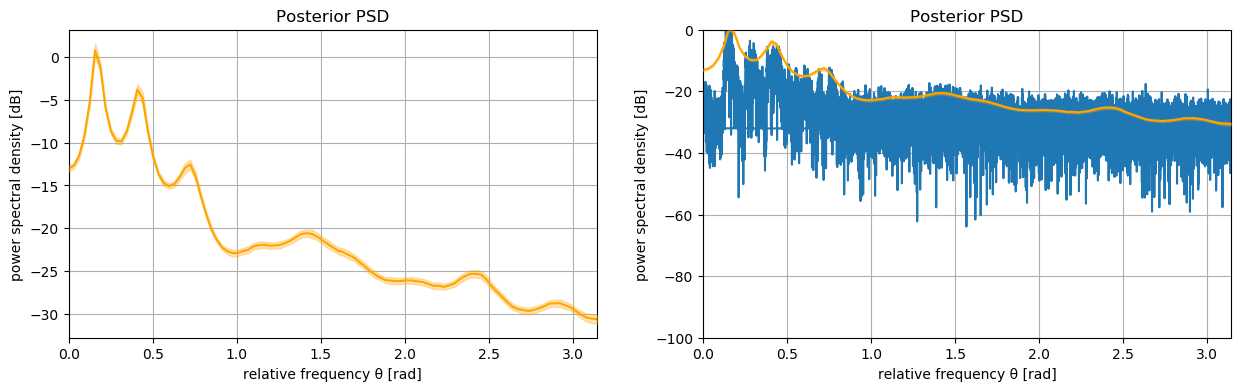

In [15]:
μ_θ_cur = params["mean_theta"]
Λ_θ_cur = params["precision_theta"]
a_γ_cur = a_γ_mem[end]
b_γ_cur = b_γ_mem[end]

θ, γ = AR_distributions(μ_θ_cur, Λ_θ_cur, a_γ_cur, b_γ_cur)
mean_psd, std_psd = summary_psd(θ, γ)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency θ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;

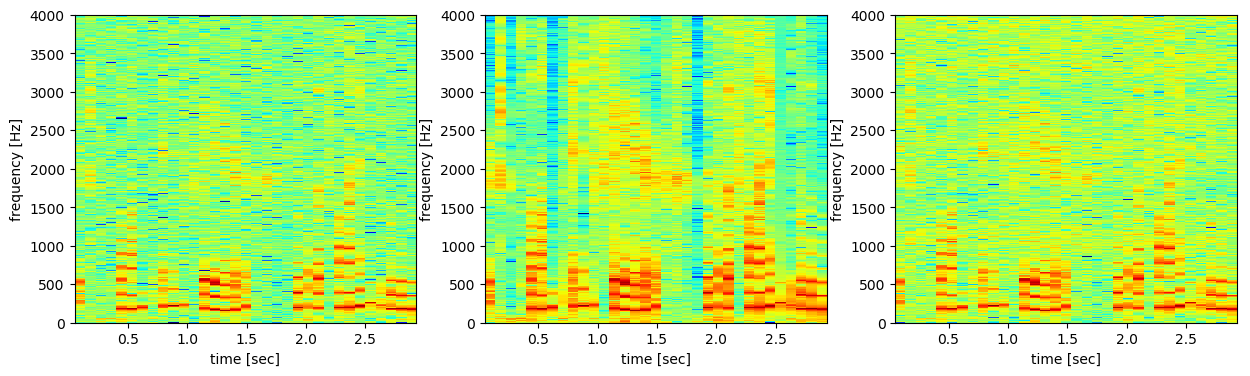

In [16]:
_, ax = subplots(ncols=3, figsize=(15,4))
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[1])
plot_spectrogram(spectrogram(x_time_clean, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])
plot_spectrogram(spectrogram(μ_x_pred, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])


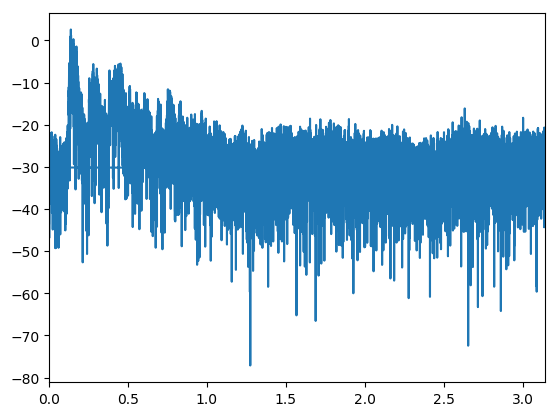

(0, 3.141592653589793)

In [19]:
plt.plot(FFTW.fftfreq(length(μ_x_pred), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(μ_x_pred)).^2)./length(μ_x_pred)))
plt.xlim(0, pi)